In [1]:
import os
import sys

from ng_utilities import *

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

import neuroglancer
import cv2

stack = 'MD585'

ENABLE_UPLOAD_S3 is not set, default to False.
ENABLE_DOWNLOAD_S3 is not set, default to False.


Setting environment for Precision WorkStation for Alex Newberry
{'MD589': 0.46, 'MD585': 0.46, 'UCSD001': 0.325, 'MD594': 0.46}
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_cropbox.ini


Seems you are using operation INIs to provide cropbox.
Seems you are using operation INIs to provide cropbox.
Seems you are using operation INIs to provide cropbox.
Seems you are using operation INIs to provide cropbox.
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Failed to cache MD590 anchor: ini file /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD590/operation_configs/from_none_to_aligned.ini does not exist.
File does not exist: /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD590/MD590_sorted_filenames.txt
Failed to cache MD590 sections_to_filenames: 
File does not exist: /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD590/MD590_sorted_filenames.txt
Failed to cache MD590 filenames_to_sections: 
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Failed to cache MD590 section_limits: ini file /media/alexn/BstemAt

## How to Load SimpleGlobal and Local Volumes

In [2]:
def image_contour_generator( stack, structure, use_local_alignment = True, image_prep = 2, threshold=0.5):

    if use_local_alignment:
        # Load local transformed volumes
        str_alignment_spec = load_json(fn_vis_structures)[structure]
        vol = DataManager.load_transformed_volume_v2(alignment_spec = str_alignment_spec, 
                                                        return_origin_instead_of_bbox = True,
                                                       structure = structure)
    else:
        # Load simple global volumes
        str_alignment_spec = load_json(fn_vis_global)
        vol = DataManager.load_transformed_volume_v2(alignment_spec = global_alignment_spec, 
                                                                     return_origin_instead_of_bbox = True,
                                                                    structure = structure)


    # Load collection of bounding boxes for every structure
    registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners = \
            load_json(os.path.join(ROOT_DIR, 'CSHL_simple_global_registration', \
                                    stack + '_registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners.json'))
    # Load cropping box for structure. Only need the valid min and max sections though
    (_, _, secmin), (_, _, secmax) = registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[structure]
    # Load range of sections for particular structure
    valid_secmin = 1
    valid_secmax = 999
    section_margin = 50 # 1000um margin / 20um per slice
    atlas_structures_wrt_wholebrainWithMargin_sections = \
        range(max(secmin - section_margin, valid_secmin), min(secmax + 1 + section_margin, valid_secmax))

    # Choose thresholds for probability volumes
    levels = [threshold, 0.9]


    # LOAD CONTOURS FROM VOLUME
    str_contour = get_structure_contours_from_structure_volumes_v3(volumes={structure: vol}, stack=stack, 
                                                         sections=atlas_structures_wrt_wholebrainWithMargin_sections,
                                                        resolution='10.0um', level=levels, sample_every=5)

    # Check number sections that the contours are present on 
    str_keys = str_contour.keys()
    valid_sections = []

    for key in str_keys:
        if isinstance(key,int) and key>1:
            valid_sections.append(key)
            # Need to check individual "levels" are on this section as well. 
            #    (0.1 threshold spans more slices than 0.9)
    valid_sections.sort()
    print 'Number of valid sections:'
    num_valid_sections = len(valid_sections)
    print num_valid_sections
    first_sec = valid_sections[0]
    last_sec = valid_sections[len(valid_sections)-1]
    print 'First valid section:',first_sec
    print 'Last valid section:',last_sec
    print 'num_valid_sections:',num_valid_sections
    print '\n\n'

    #print str_contour[ valid_sections[0] ][structure][ levels[0] ]



    # LOAD prep5->prep2 cropbox
    if image_prep==5:
        # wholeslice_to_brainstem = -from_padded_to_wholeslice, from_padded_to_brainstem
        ini_fp = os.environ['DATA_ROOTDIR']+'CSHL_data_processed/'+stack+'/operation_configs/from_padded_to_brainstem.ini'
        with open(ini_fp,'r') as fn:
            contents_list = fn.read().split('\n')
        for line in contents_list:
            if 'rostral_limit' in line:
                rostral_limit = int( line.split(' ')[2] )
            if 'dorsal_limit' in line:
                dorsal_limit = int( line.split(' ')[2] )
        ini_fp = os.environ['DATA_ROOTDIR']+'CSHL_data_processed/'+stack+'/operation_configs/from_padded_to_wholeslice.ini'
        with open(ini_fp,'r') as fn:
            contents_list = fn.read().split('\n')
        for line in contents_list:
            if 'rostral_limit' in line:
                rostral_limit = rostral_limit - int( line.split(' ')[2] )
            if 'dorsal_limit' in line:
                dorsal_limit = dorsal_limit - int( line.split(' ')[2] )
#         rostral_limit = rostral_limit
#         dorsal_limit = dorsal_limit
        # DONE LOADING PREP5 OFFSETS
    elif image_prep==2:
        rostral_limit = 0
        dorsal_limit = 0

    # PLOT Contours
    contour_str = str_contour[ valid_sections[num_valid_sections/2] ][structure][ levels[0] ]
    # Downsample
    y_len, x_len = np.shape(contour_str)
    x_list = []
    y_list = []
    for y in range(y_len):
        x_list.append(rostral_limit + contour_str[y][0]/32)
        y_list.append(dorsal_limit + contour_str[y][1]/32)

    # PLOT Structure overlayed on thumbnail image
    sorted_fns = DataManager.load_sorted_filenames(stack=stack)[0].keys()
    # fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol='thumbnail', version='gray', fn=sorted_fns[int(len(sorted_fns)/2)])
    img_fn = metadata_cache['sections_to_filenames'][stack][last_sec-num_valid_sections/2]
    fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=image_prep, resol='thumbnail', version='gray', fn=img_fn)
    
#     img = imread(fp)
#     plt.imshow( img, cmap='gray' )
#     plt.scatter(x_list,y_list,s=1, color='r')
#     plt.show()
    
    return str_contour, first_sec, last_sec

In [3]:
def add_structure_to_neuroglancer( str_contour, structure, color_radius=4, xy_ng_resolution_um=10, threshold=0.5, color=1, solid_volume=False, save_results=False ):
    xy_ng_resolution_um = xy_ng_resolution_um # X and Y voxel length in microns
    color_radius = color_radius*(10.0/xy_ng_resolution_um)**0.5

    # Max and Min X/Y Values given random initial values that will be replaced
    # X and Y resolution will be specified by the user in microns (xy_ng_resolution_umx by y_ng_resolution_um)
    max_x = 0
    max_y = 0
    min_x = 9999999
    min_y = 9999999
    # 'min_z' is the relative starting section (if the prep2 sections start at slice 100, and the structure starts at slice 110, min_z is 10 )
    # Z resolution is 20um for simple 1-1 correspondance with section thickness
    max_z = (last_sec-ng_section_min)
    min_z = (first_sec-ng_section_min)
    # Scaling factor is (0.46/10). Scaling from resolution of 0.46 microns to 10 microns. 
    scale_xy = 0.46/xy_ng_resolution_um

    # X,Y are 10um voxels. Z is 20um voxels. 
    # str_contour_ng_resolution is the previous contour data rescaled to neuroglancer resolution
    str_contour_ng_resolution = {}

    for section in str_contour:
        # Load (X,Y) coordinates on this contour
        section_contours = str_contour[ section ][structure][ threshold ]
        # (X,Y) coordinates will be rescaled to the new resolution and placed here
        # str_contour_ng_resolution starts at z=0 for simplicity, must provide section offset later on
        str_contour_ng_resolution[section-first_sec] = []
        # Number of (X,Y) coordinates
        num_contours = len( section_contours )
        # Cycle through each coordinate pair
        for coordinate_pair in range(num_contours):

            curr_coors = section_contours[ coordinate_pair ]
            # Rescale coordinate pair and add to new contour dictionary
            str_contour_ng_resolution[section-first_sec].append( [scale_xy*curr_coors[0],scale_xy*curr_coors[1]] )
            # Replace Min/Max X/Y values with new extremes
            min_x = min( scale_xy*curr_coors[0], min_x)
            min_y = min( scale_xy*curr_coors[1], min_y)
            max_x = max( scale_xy*curr_coors[0], max_x)
            max_y = max( scale_xy*curr_coors[1], max_y)


    # Cast max and min values to int as they are used to build 3D numpy matrix
    max_x = int( np.ceil(max_x) ) 
    max_y = int( np.ceil(max_y) )
    min_x = int( np.floor(min_x) )
    min_y = int( np.floor(min_y) )

    # Create empty 'structure_volume' using min and max values found earlier
    structure_volume = np.zeros( (max_z-min_z, max_y-min_y, max_x-min_x), dtype = np.uint8 )
    z_voxels,y_voxels,x_voxels =  np.shape(structure_volume)
    print  np.shape(structure_volume)

    # Go through every slice. For every slice color in the voxels corrosponding to the contour's coordinate pair
    for slice in range(z_voxels):
        slice_contour = np.asarray( str_contour_ng_resolution[slice] )

        for xy_pair in slice_contour:
            x_voxel = int(xy_pair[0])-min_x
            y_voxel = int(xy_pair[1])-min_y
            
            structure_volume[slice,y_voxel,x_voxel] = color

            # Instead of coloring a single voxel, color all in a specified radius from this voxel!
            lower_bnd_offset = int( np.floor(1-color_radius) )
            upper_bnd_offset = int( np.ceil(color_radius) )
            for x_coor_color_radius in range( lower_bnd_offset, upper_bnd_offset):
                for y_coor_color_radius in range( lower_bnd_offset, upper_bnd_offset):

                    x_displaced_voxel = x_voxel + x_coor_color_radius
                    y_displaced_voxel = y_voxel + y_coor_color_radius
                    distance = ( (y_voxel-y_displaced_voxel)**2 + (x_voxel-x_displaced_voxel)**2 )**0.5
                    # If the temporary coordinate is within the specified radius AND inside the 3D matrix
                    if distance<color_radius and \
                    x_displaced_voxel<x_voxels and \
                    y_displaced_voxel<y_voxels and \
                    x_displaced_voxel>0 and \
                    y_displaced_voxel>0:
                        try:
                            # Set temporary coordinate to be visible
                            structure_volume[slice,y_displaced_voxel,x_displaced_voxel] = color
                        except:
                            pass
                        
        if solid_volume:
            structure_volume[slice,:,:] = fill_in_structure( structure_volume[slice,:,:], color )

    # structure_volume

    display_name = structure+'_'+str(threshold)+'_'+str(color)
    
    hc_x_offset = -42*10/xy_ng_resolution_um
    hc_y_offset = 25*10/xy_ng_resolution_um
    
    
    with viewer.txn() as s:
#         s.layers['image'] = neuroglancer.ImageLayer(source='precomputed://https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/MD585_fullres')
        s.layers[ display_name ] = neuroglancer.SegmentationLayer(
            source = neuroglancer.LocalVolume(
                data=structure_volume, # Z,Y,X
                voxel_size=[ xy_ng_resolution_um*1000, xy_ng_resolution_um*1000,20000], # X Y Z
                voxel_offset = [ min_x+hc_x_offset, min_y+hc_y_offset, min_z] # X Y Z
            ),
            segments = [color]
    )
        
    if save_results:

        fp_volumes = '/home/alexn/Desktop/neuroglancer_binary_volumes/volumes_'+xy_ng_resolution_um+'um/'
        np.save( fp_volumes+structure+'_volume.npy',structure_volume)
        
        fp_offsets = '/home/alexn/Desktop/neuroglancer_binary_volumes/offsets_'+xy_ng_resolution_um+'um/'
        with open(fp_offsets+structure+'_offsets.txt', 'w') as offset_file:
            insert_str =  str(min_x+hc_x_offset)+" "+str(min_y+hc_y_offset)+" "+str(min_z)
            offset_file.write(  insert_str )
    
    return structure_volume

# Neuroglancer code

In [4]:
#Replace: viewer = neuroglancer.Viewer()

#With: 
neuroglancer.set_server_bind_address('0.0.0.0')
viewer = neuroglancer.Viewer()
print(viewer)

ip_name = !hostname -I
print('http://' + ip_name[0].strip() + ':' + viewer.get_viewer_url().split(':')[2]) ##Remote URL


viewer # port 41989

http://yuncong-Precision-WorkStation-T7500:42429/v/eeedaa9c477ee33c9f65acd9ab7acb7a8bd9e5de/
http://132.239.73.85 172.17.0.1:42429/v/eeedaa9c477ee33c9f65acd9ab7acb7a8bd9e5de/


http://yuncong-Precision-WorkStation-T7500:42429/v/eeedaa9c477ee33c9f65acd9ab7acb7a8bd9e5de/

In [11]:
# Sets 'Image' layer to be MD585 prep2 images from S3
with viewer.txn() as s:
    s.layers['image'] = neuroglancer.ImageLayer(source='precomputed://https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/MD585_fullres')
    
    # Resets X/Y/Z plane orientation
    s.navigation.pose.orientation = [0,0,0,1]
    # Zooms out 
#     s.navigation.zoomFactor = 10000 # If 4panel
    s.navigation.zoomFactor = 5000 # If xy
    
    # Resets 3D Viewer Orientation
    s.perspectiveOrientation = [0,0,0,1]
    # Zooms out
    s.perspectiveZoom = 75000
    
    s.layout = 'xy'

In [14]:
# Resets the viewer
with viewer.txn() as s:
    # Resets X/Y/Z plane orientation
    s.navigation.pose.orientation = [0,0,0,1]
    # Zooms out 
    s.navigation.zoomFactor = 10000
    
    # Resets 3D Viewer Orientation
    s.perspectiveOrientation = [0,0,0,1]
    # Zooms out
    s.perspectiveZoom = 75000
    
    # Not necessary, just restates the voxel sizes of the image
    s.navigation.pose.position.voxelSize = [460,460,20000]
    # Sets Viewer's center location
    s.navigation.pose.position.voxelCoordinates = [8192,6000,134]

In [52]:
with viewer.txn() as s:
#     s.layout = '3d'
    s.layout = '4panel'
#     s.layout = 'xy'

In [63]:
neuroglancer.stop()

In [35]:
with viewer.txn() as s:
    print s.layers['navigation']

ManagedLayer("IC_0.2_5",{"source": "python://86c61c4cb6e9823ea3003304021b1f364d45d4e9.fd5eb334dc361cdfc331a91792eca0461d8d1a04", "type": "segmentation", "segments": ["5"], "name": "IC_0.2_5"})


# Populate Viewer

In [6]:
detector_id = 19
# detector_id = 799

fn_vis_global,fn_vis_structures = create_alignment_specs(stack, detector_id)

In [7]:
# For current MD585 stack on neuroglancer
ng_section_min = 83
ng_section_max = 536
ng_total_sections = 268 # 536 voxels

In [8]:
def fill_in_structure( voxel_sheet, color ):
    contour_coordinates = []
    y_len, x_len = np.shape(voxel_sheet )
    
    for y in range(y_len):
        for x in range(x_len):
            # If this pixel is colored in
            if not voxel_sheet[y,x] == 0:
                contour_coordinates.append( [y,x] )
    
    for y in range(y_len):
        for x in range(x_len):
            has_lr, has_ur, has_ll, has_ul = [False,False,False,False]
            
            for coordinate in contour_coordinates:
                coor_y = coordinate[0]
                coor_x = coordinate[1]
                
                if coor_y < y and coor_x < x:
                    has_ll = True
                if coor_y < y and coor_x > x:
                    has_lr = True
                if coor_y > y and coor_x < x:
                    has_ul = True
                if coor_y > y and coor_x > x:
                    has_ur = True
                    
            if has_lr==True and has_ur==True and has_ll==True and has_ul==True:
                voxel_sheet[y,x] = color
    return voxel_sheet

In [67]:
stack = 'MD585'
structure = 'IC'
# color_codes{'blue:'1,'red',2,'yellow':3}

str_contour, first_sec, last_sec = image_contour_generator( stack, structure, use_local_alignment=True, image_prep=2, threshold=0.2)

ng_structure_volume = add_structure_to_neuroglancer( str_contour, structure, color_radius=2, xy_ng_resolution_um=10, threshold=0.2, color=1, solid_volume=True, save_results=False )

/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
192
First valid section: 127
Last valid section: 318
num_valid_sections: 192



(191, 189, 160)


In [10]:
stack = 'MD585'

for structure in all_structures_total:
    str_contour, first_sec, last_sec = image_contour_generator( stack, structure, use_local_alignment=True, image_prep=2, threshold=0.2)

    add_structure_to_neuroglancer( str_contour, structure, color_radius=5, xy_ng_resolution_um=10, threshold=0.2, color=1, solid_volume=False, save_results=False  )

/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 10 ([6, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 52 ([2, 1]). Use the longest one.
contour has less than three vertices. Ignore.


Number of valid sections:
21
First valid section: 188
Last valid section: 208
num_valid_sections: 21



(20, 30, 58)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
44
First valid section: 180
Last valid section: 223
num_valid_sections: 44



(43, 62, 114)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
87
First valid section: 175
Last valid section: 261
num_valid_sections: 87



(86, 98, 130)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
5 contours of reconstructed volume is found at position 25 ([23, 2, 1, 1, 1]). Use the longest one.


Number of valid sections:
178
First valid section: 135
Last valid section: 312
num_valid_sections: 178



(177, 207, 218)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
192
First valid section: 127
Last valid section: 318
num_valid_sections: 192



(191, 189, 160)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 61 ([8, 7]). Use the longest one.
2 contours of reconstructed volume is found at position 55 ([17, 1]). Use the longest one.


Number of valid sections:
28
First valid section: 269
Last valid section: 296
num_valid_sections: 28



(27, 79, 61)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
25
First valid section: 135
Last valid section: 159
num_valid_sections: 25



(24, 80, 67)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
12
First valid section: 231
Last valid section: 242
num_valid_sections: 12



(11, 22, 24)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
12
First valid section: 186
Last valid section: 197
num_valid_sections: 12



(11, 24, 23)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 15 ([46, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 47 ([50, 1]). Use the longest one.


Number of valid sections:
38
First valid section: 252
Last valid section: 289
num_valid_sections: 38



(37, 87, 86)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 98 ([11, 2]). Use the longest one.


Number of valid sections:
47
First valid section: 137
Last valid section: 183
num_valid_sections: 47



(46, 58, 96)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
85
First valid section: 226
Last valid section: 310
num_valid_sections: 85



(84, 78, 70)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
3 contours of reconstructed volume is found at position 23 ([1, 1, 1]). Use the longest one.
contour has less than three vertices. Ignore.


Number of valid sections:
77
First valid section: 111
Last valid section: 187
num_valid_sections: 77



(76, 44, 118)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
11
First valid section: 260
Last valid section: 270
num_valid_sections: 11



(10, 24, 45)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
8
First valid section: 132
Last valid section: 139
num_valid_sections: 8



(7, 25, 48)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 17 ([17, 1]). Use the longest one.


Number of valid sections:
18
First valid section: 248
Last valid section: 265
num_valid_sections: 18



(17, 66, 67)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 7 ([4, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 13 ([15, 3]). Use the longest one.


Number of valid sections:
17
First valid section: 164
Last valid section: 180
num_valid_sections: 17



(16, 66, 70)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 50 ([76, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 52 ([59, 1]). Use the longest one.


Number of valid sections:
41
First valid section: 244
Last valid section: 284
num_valid_sections: 41



(40, 81, 127)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 99 ([5, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 89 ([13, 1, 1]). Use the longest one.


Number of valid sections:
45
First valid section: 137
Last valid section: 181
num_valid_sections: 45



(44, 64, 118)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 10 ([32, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 12 ([47, 2]). Use the longest one.


Number of valid sections:
57
First valid section: 224
Last valid section: 280
num_valid_sections: 57



(56, 92, 101)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 114 ([17, 9]). Use the longest one.


Number of valid sections:
56
First valid section: 162
Last valid section: 217
num_valid_sections: 56



(55, 94, 102)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
3 contours of reconstructed volume is found at position 18 ([5, 2, 1]). Use the longest one.


Number of valid sections:
40
First valid section: 205
Last valid section: 244
num_valid_sections: 40



(39, 37, 79)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
5 contours of reconstructed volume is found at position 10 ([25, 3, 2, 1, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 16 ([47, 3]). Use the longest one.


Number of valid sections:
25
First valid section: 183
Last valid section: 207
num_valid_sections: 25



(24, 31, 94)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 28 ([20, 7]). Use the longest one.
2 contours of reconstructed volume is found at position 34 ([51, 5]). Use the longest one.
2 contours of reconstructed volume is found at position 104 ([13, 5]). Use the longest one.
2 contours of reconstructed volume is found at position 36 ([9, 6]). Use the longest one.
2 contours of reconstructed volume is found at position 96 ([3, 1]). Use the longest one.


Number of valid sections:
39
First valid section: 279
Last valid section: 317
num_valid_sections: 39



(38, 194, 85)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.
contour has less than three vertices. Ignore.
3 contours of reconstructed volume is found at position 87 ([3, 2, 1]). Use the longest one.


Number of valid sections:
44
First valid section: 120
Last valid section: 163
num_valid_sections: 44



(43, 192, 77)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
33
First valid section: 232
Last valid section: 264
num_valid_sections: 33



(32, 56, 71)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.


Number of valid sections:
32
First valid section: 180
Last valid section: 211
num_valid_sections: 32



(31, 58, 77)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 78 ([7, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 84 ([4, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 86 ([5, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 88 ([2, 1]). Use the longest one.
contour has less than three vertices. Ignore.
3 contours of reconstructed volume is found at position 90 ([2, 1, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 92 ([3, 2]). Use the longest one.


Number of valid sections:
54
First valid section: 233
Last valid section: 286
num_valid_sections: 54



(53, 48, 93)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 36 ([3, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 38 ([3, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 46 ([6, 1]). Use the longest one.


Number of valid sections:
53
First valid section: 140
Last valid section: 192
num_valid_sections: 53



(52, 91, 61)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 145 ([24, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 147 ([7, 3, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 17 ([11, 3]). Use the longest one.


Number of valid sections:
71
First valid section: 260
Last valid section: 330
num_valid_sections: 71



(70, 114, 148)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 140 ([9, 2]). Use the longest one.


Number of valid sections:
71
First valid section: 119
Last valid section: 189
num_valid_sections: 71



(70, 145, 116)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 11 ([27, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 37 ([4, 2, 1]). Use the longest one.


Number of valid sections:
20
First valid section: 217
Last valid section: 236
num_valid_sections: 20



(19, 41, 53)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
24
First valid section: 205
Last valid section: 228
num_valid_sections: 24



(23, 39, 52)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.
contour has less than three vertices. Ignore.


Number of valid sections:
10
First valid section: 228
Last valid section: 237
num_valid_sections: 10



(9, 19, 17)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.
contour has less than three vertices. Ignore.


Number of valid sections:
9
First valid section: 203
Last valid section: 211
num_valid_sections: 9



(8, 19, 16)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 11 ([5, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 13 ([22, 6]). Use the longest one.
2 contours of reconstructed volume is found at position 101 ([13, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 75 ([69, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 93 ([11, 3, 3]). Use the longest one.


Number of valid sections:
46
First valid section: 270
Last valid section: 315
num_valid_sections: 46



(45, 119, 122)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
4 contours of reconstructed volume is found at position 14 ([30, 2, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 94 ([42, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 96 ([37, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 98 ([10, 7]). Use the longest one.
2 contours of reconstructed volume is found at position 20 ([2, 1]). Use the longest one.
contour has less than three vertices. Ignore.
3 contours of reconstructed volume is found at position 40 ([68, 1, 1]). Use the longest one.


Number of valid sections:
44
First valid section: 100
Last valid section: 143
num_valid_sections: 44



(43, 125, 89)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 81 ([115, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 83 ([105, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 85 ([83, 3]). Use the longest one.
5 contours of reconstructed volume is found at position 93 ([12, 6, 4, 3, 2]). Use the longest one.
4 contours of reconstructed volume is found at position 75 ([89, 3, 3, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 77 ([68, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 83 ([17, 1]). Use the longest one.


Number of valid sections:
41
First valid section: 276
Last valid section: 316
num_valid_sections: 41



(40, 135, 166)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 18 ([17, 15]). Use the longest one.
3 contours of reconstructed volume is found at position 20 ([51, 35, 1]). Use the longest one.
5 contours of reconstructed volume is found at position 22 ([85, 46, 3, 3, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 76 ([63, 4]). Use the longest one.
2 contours of reconstructed volume is found at position 84 ([46, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 90 ([4, 2, 2]). Use the longest one.
contour has less than three vertices. Ignore.
3 contours of reconstructed volume is found at position 28 ([15, 2, 2]). Use the longest one.
6 contours of reconstructed volume is found at position 30 ([56, 28, 11, 1, 1, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 32 ([84, 40, 1]). Use the longest one.
3 contours of reconstructed volume is foun

Number of valid sections:
37
First valid section: 112
Last valid section: 148
num_valid_sections: 37



(36, 122, 185)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 51 ([7, 5]). Use the longest one.
2 contours of reconstructed volume is found at position 53 ([10, 7]). Use the longest one.
2 contours of reconstructed volume is found at position 55 ([12, 9]). Use the longest one.
2 contours of reconstructed volume is found at position 57 ([13, 10]). Use the longest one.
2 contours of reconstructed volume is found at position 63 ([27, 11]). Use the longest one.
2 contours of reconstructed volume is found at position 65 ([29, 17]). Use the longest one.
2 contours of reconstructed volume is found at position 67 ([30, 21]). Use the longest one.
2 contours of reconstructed volume is found at position 69 ([30, 23]). Use the longest one.
2 contours of reconstructed volume is found at position 71 ([33, 27]). Use the longest one.
2 contours of reconstructed volume is found at position 73 ([35, 29]). Use the longest one.
3 contours of reconstructed v

Number of valid sections:
101
First valid section: 196
Last valid section: 296
num_valid_sections: 101



(100, 128, 108)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 27 ([11, 7]). Use the longest one.
2 contours of reconstructed volume is found at position 89 ([77, 1]). Use the longest one.


Number of valid sections:
79
First valid section: 103
Last valid section: 181
num_valid_sections: 79



(78, 150, 141)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.
contour has less than three vertices. Ignore.


Number of valid sections:
15
First valid section: 298
Last valid section: 312
num_valid_sections: 15



(14, 70, 56)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 9 ([1, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 11 ([25, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 17 ([5, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 31 ([1, 1]). Use the longest one.
contour has less than three vertices. Ignore.


Number of valid sections:
15
First valid section: 125
Last valid section: 139
num_valid_sections: 15



(14, 77, 45)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 36 ([9, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 48 ([15, 4]). Use the longest one.
2 contours of reconstructed volume is found at position 54 ([11, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 56 ([3, 1]). Use the longest one.


Number of valid sections:
31
First valid section: 194
Last valid section: 224
num_valid_sections: 31



(30, 56, 105)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 42 ([48, 1]). Use the longest one.
4 contours of reconstructed volume is found at position 44 ([20, 8, 3, 2]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 22 ([6, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 32 ([24, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 34 ([25, 7, 1]). Use the longest one.
6 contours of reconstructed volume is found at position 38 ([7, 2, 2, 2, 2, 1]). Use the longest one.


Number of valid sections:
18
First valid section: 176
Last valid section: 193
num_valid_sections: 18



(17, 61, 112)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
5 contours of reconstructed volume is found at position 87 ([6, 2, 1, 1, 1]). Use the longest one.


Number of valid sections:
44
First valid section: 306
Last valid section: 349
num_valid_sections: 44



(43, 77, 104)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
4 contours of reconstructed volume is found at position 11 ([12, 6, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 13 ([39, 1]). Use the longest one.
4 contours of reconstructed volume is found at position 19 ([20, 3, 2, 1]). Use the longest one.


Number of valid sections:
41
First valid section: 70
Last valid section: 110
num_valid_sections: 41



(40, 88, 116)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 80 ([43, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 82 ([41, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 72 ([35, 1]). Use the longest one.
5 contours of reconstructed volume is found at position 80 ([13, 2, 2, 1, 1]). Use the longest one.


Number of valid sections:
39
First valid section: 303
Last valid section: 341
num_valid_sections: 39



(38, 101, 65)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.
3 contours of reconstructed volume is found at position 14 ([12, 4, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 52 ([5, 2]). Use the longest one.


Number of valid sections:
31
First valid section: 82
Last valid section: 112
num_valid_sections: 31



(30, 74, 101)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 35 ([1, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 47 ([1, 1]). Use the longest one.
contour has less than three vertices. Ignore.


Number of valid sections:
56
First valid section: 283
Last valid section: 338
num_valid_sections: 56



(55, 67, 101)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 10 ([11, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 18 ([3, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 102 ([3, 2]). Use the longest one.


Number of valid sections:
53
First valid section: 84
Last valid section: 136
num_valid_sections: 53



(52, 71, 108)


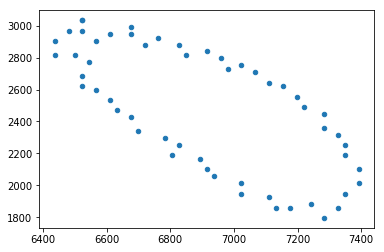

In [41]:
x_list = []
y_list = []
min_x = 9999999
min_y = 9999999
max_x = 0
max_y = 0


coor_list = str_contour[135]['IC'][0.5]
for x, y in coor_list:
    x_list.append(x)
    y_list.append(y)

plt.scatter(x_list, y_list, s=20)

# Need to: design function that fills in all points in between

In [25]:
! aws s3 cp --recursive /home/alexn/Desktop/neuroglancer_binary_volumes/ s3://test-bucket-sid/alex_neuroglancer_volumes

upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/5N_L_offsets.txt to s3://test-bucket-sid/alex_neuroglancer_volumes/offsets/5N_L_offsets.txt
upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/4N_L_offsets.txt to s3://test-bucket-sid/alex_neuroglancer_volumes/offsets/4N_L_offsets.txt
upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/6N_L_offsets.txt to s3://test-bucket-sid/alex_neuroglancer_volumes/offsets/6N_L_offsets.txt
upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/6N_R_offsets.txt to s3://test-bucket-sid/alex_neuroglancer_volumes/offsets/6N_R_offsets.txt
upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/4N_R_offsets.txt to s3://test-bucket-sid/alex_neuroglancer_volumes/offsets/4N_R_offsets.txt
upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/10N_R_offsets.txt to s3://test-bucket-sid/alex_neuroglancer_volumes/offsets/10N_R_offsets.txt
upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/7N_R_offsets.txt to

upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/10N_L_volume.npy to s3://test-bucket-sid/alex_neuroglancer_volumes/volumes/10N_L_volume.npy
upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/3N_R_volume.npy to s3://test-bucket-sid/alex_neuroglancer_volumes/volumes/3N_R_volume.npy
upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/6N_L_volume.npy to s3://test-bucket-sid/alex_neuroglancer_volumes/volumes/6N_L_volume.npy
upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/10N_R_volume.npy to s3://test-bucket-sid/alex_neuroglancer_volumes/volumes/10N_R_volume.npy
upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/6N_R_volume.npy to s3://test-bucket-sid/alex_neuroglancer_volumes/volumes/6N_R_volume.npy
upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/12N_volume.npy to s3://test-bucket-sid/alex_neuroglancer_volumes/volumes/12N_volume.npy
upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/5N_L_volume.npy to s3://test-bu

# End Neuroglancer Code

In [ ]:
# wholeslice_to_brainstem = -from_padded_to_wholeslice, from_padded_to_brainstem

#from_padded_to_wholeslice
rostral_limit = 50
caudal_limit = 1188
dorsal_limit = 21
ventral_limit = 738

#from_padded_to_brainstem
rostral_limit = 521
caudal_limit = 1057
dorsal_limit = 128
ventral_limit = 465